In [ ]:
%pip install gym

In [ ]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from collections import deque
import random
import matplotlib.pyplot as plt
import itertools

env = gym.make('Blackjack-v1')

In [3]:
observation_space_shape = len(env.observation_space.sample())

# DQN model
def build_model(hidden_units, learning_rate):
    model = Sequential()
    model.add(Dense(hidden_units, activation='relu', input_shape=(observation_space_shape,)))
    model.add(Dense(hidden_units, activation='relu'))
    model.add(Dense(env.action_space.n, activation='linear'))
    model.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate))
    return model

In [4]:
def train_dqn(hidden_units, learning_rate, epsilon_decay, gamma, validation):
    # Define the experience replay buffer
    buffer_size = 20000
    batch_size = 32
    experience_buffer = deque(maxlen=buffer_size)

    # Define the epsilon-greedy policy
    epsilon = 1.0
    epsilon_decay = 0.995
    epsilon_min = 0.01

    # Hyperparameters
    target_update_freq = 5000
    reward_clip = (-1, 1)

    # Tracking variables
    episode_rewards = []
    epsilon_values = []
    losses = []
    win_rate = []
    max_q_values = []

    # Building the model
    model = build_model(hidden_units, learning_rate)
    target_model = build_model(hidden_units, learning_rate)
    target_model.set_weights(model.get_weights())

    training_reward = 0

    for episode in range(500):
        state = env.reset()
        done = False
        total_rewards = 0  # Track total rewards for the episode
        steps = 0
        max_q_value = float('-inf')

        while not done:
            # Select an action using epsilon-greedy policy
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                state_array = np.array(state).reshape(1, -1)
                q_values = model.predict(state_array, verbose=0)
                action = np.argmax(q_values)
                max_q_value = max(max_q_value, np.max(q_values))  # Track the max Q-value

            # Take the action and observe the next state and reward
            next_state, reward, done, _ = env.step(action)
            total_rewards += reward  # Accumulate rewards for the episode

            # Clip rewards if necessary
            reward = np.clip(reward, *reward_clip)

            # Store the experience in the buffer
            experience_buffer.append((state, action, reward, next_state, done))

            # Update the state
            state = next_state
            steps += 1

        # Update the epsilon value
        epsilon *= epsilon_decay
        epsilon = max(epsilon, epsilon_min)

        # Sample a batch from the experience buffer and train the model
        if len(experience_buffer) >= batch_size:
            batch = random.sample(experience_buffer, batch_size)
            states, actions, rewards, next_states, dones = zip(*batch)
            states = np.array(states)
            next_states = np.array(next_states)

            # Compute the target values
            targets = model.predict(states, verbose=0)
            next_q_values = target_model.predict(next_states, verbose=0)
            for i in range(batch_size):
                targets[i][actions[i]] = rewards[i] + gamma * np.amax(next_q_values[i]) * (1 - dones[i])

            # Train the model and track the loss
            history = model.fit(states, targets, epochs=1, verbose=0)
            losses.append(history.history['loss'][0])

            # Update the target network
            if episode % target_update_freq == 0:
                target_model.set_weights(model.get_weights())

        # Track rewards and epsilon
        episode_rewards.append(total_rewards)
        epsilon_values.append(epsilon)
        win_rate.append(1 if total_rewards > 0 else 0)  # Track win rate based on total_rewards
        max_q_values.append(max_q_value)

        # Print the episode rewards every 100 episodes
        if (episode + 1) % 100 == 0:
            print(f'Episode {episode + 1}, Rewards: {total_rewards}, Epsilon: {epsilon:.3f}')

        env.close()

        training_reward += total_rewards
        average_reward = training_reward / 500

    if validation:
      return average_reward
    else:
      return model, episode_rewards, epsilon_values, win_rate, losses, max_q_values


In [ ]:
# Define hyperparameter ranges
hidden_units_choices = [24, 48, 64, 128]
learning_rate_choices = [1e-5, 1e-4, 1e-3, 1e-2]
epsilon_decay_choices = [0.99, 0.995, 0.999]
gamma_choices = [0.9, 0.95, 0.99]

best_reward = -float('inf')
best_params = None

# Grid search
for hidden_units, learning_rate, epsilon_decay, gamma in itertools.product(hidden_units_choices, learning_rate_choices, epsilon_decay_choices, gamma_choices):
    print(f"Training with hidden_units={hidden_units}, learning_rate={learning_rate}, epsilon_decay={epsilon_decay}, gamma={gamma}")

    average_reward = train_dqn(hidden_units, learning_rate, epsilon_decay, gamma, validation=True)

    if average_reward > best_reward:
        best_reward = average_reward
        best_params = (hidden_units, learning_rate, epsilon_decay, gamma)

print("Best hyperparameters: ", best_params)
print("Best average reward: ", best_reward)


We will now train the model with the best hyperparameters found.

In [5]:
model, episode_rewards, epsilon_values, win_rate, losses, q_values = train_dqn(hidden_units=64, learning_rate=0.0001, epsilon_decay=0.99, gamma=0.9, validation=False)

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 100, Rewards: 1.0, Epsilon: 0.606
Episode 200, Rewards: -1.0, Epsilon: 0.367
Episode 300, Rewards: 0.0, Epsilon: 0.222
Episode 400, Rewards: -1.0, Epsilon: 0.135
Episode 500, Rewards: -1.0, Epsilon: 0.082


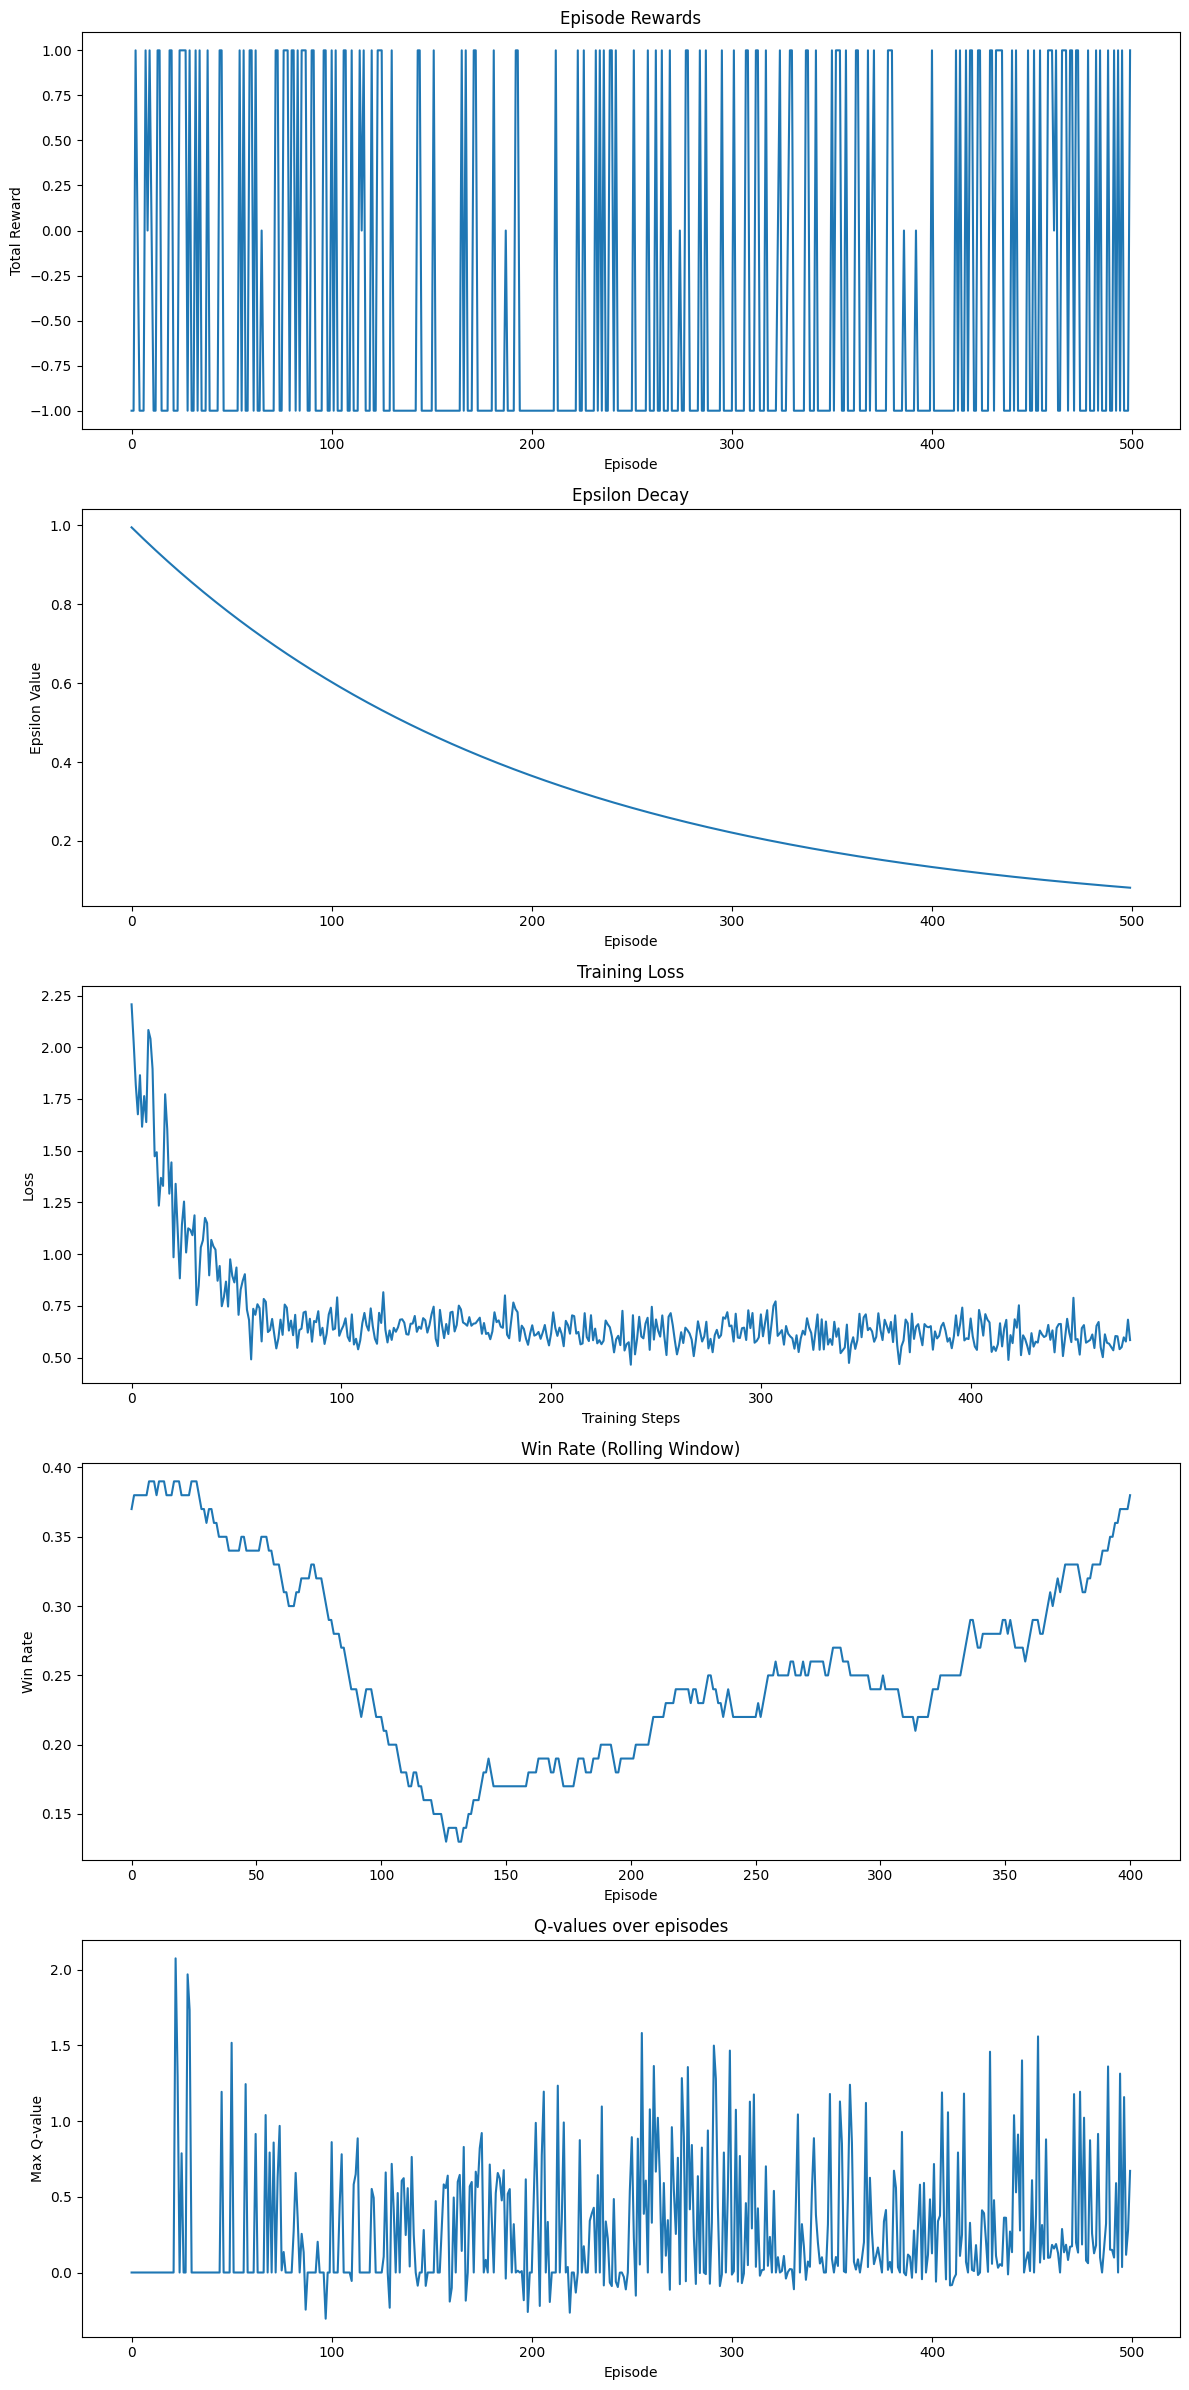

In [ ]:
# Convert lists to numpy arrays for consistency
episode_rewards = np.array(episode_rewards)
epsilon_values = np.array(epsilon_values)
losses = np.array(losses)
q_values = np.array(q_values)
q_values = np.where(q_values == float('-inf'), 0, q_values)

# Rolling window for win rate
rolling_window_size = 100
win_rate_rolling = [np.mean(win_rate[i:i + rolling_window_size]) for i in range(len(win_rate) - rolling_window_size + 1)]

# Plotting
fig, axs = plt.subplots(5, 1, figsize=(12, 24))

# Episode rewards
if len(episode_rewards) > 0:
    axs[0].plot(episode_rewards)
    axs[0].set_title('Episode Rewards')
    axs[0].set_xlabel('Episode')
    axs[0].set_ylabel('Total Reward')

# Epsilon values
if len(epsilon_values) > 0:
    axs[1].plot(epsilon_values)
    axs[1].set_title('Epsilon Decay')
    axs[1].set_xlabel('Episode')
    axs[1].set_ylabel('Epsilon Value')

# Loss values
if len(losses) > 0:
    axs[2].plot(losses)
    axs[2].set_title('Training Loss')
    axs[2].set_xlabel('Training Steps')
    axs[2].set_ylabel('Loss')

# Win rate
if len(win_rate_rolling) > 0:
    axs[3].plot(win_rate_rolling)
    axs[3].set_title('Win Rate (Rolling Window)')
    axs[3].set_xlabel('Episode')
    axs[3].set_ylabel('Win Rate')

if len(q_values) > 0:
    axs[4].plot(q_values)
    axs[4].set_title('Q-values over episodes')
    axs[4].set_xlabel('Episode')
    axs[4].set_ylabel('Max Q-value')

plt.tight_layout()
plt.show()

In [6]:
games = 10
wins = 0
losses = 0
draws = 0
verbose = True

for i in range(games):
    state = env.reset()
    done = False
    rewards = 0
    player_hand = []
    dealer_hand = []

    # Get the initial player and dealer cards
    player_hand.append(state[0])  # Player's first card
    dealer_visible_card = state[1]  # Dealer's visible card (1-10 where 1 is ace)
    dealer_hand.append(dealer_visible_card)

    while not done:
        state_array = np.array(state)
        action = np.argmax(model.predict(state_array.reshape(1, -1)))
        state, reward, done, _ = env.step(action)
        rewards += reward

        # Update the player's hand
        if action == 1:  # Hit
            player_hand.append(state[0])

    if (verbose):
      # Print the result of the game
      print("Player's hand:", [count for count in player_hand])
      print("Dealer visible hand:",dealer_visible_card)

    if rewards > 0:
        print("Win! :) ", rewards, "\n")
        wins += 1
    elif rewards == 0:
        print("Draw! :| ", rewards, "\n")
        draws += 1
    else:
        print("Loss! :( ", rewards, "\n")
        losses += 1

print("Win percentage: ", (wins/games)*100, "%\n")
print("Draw percentage: ", (draws/games)*100, "%\n")
print("Losing percentage: ", (losses/games)*100, "%\n")

1/1 [==============================] - 0s 27ms/step
Player's hand: [12, 21]
Dealer visible hand: 10
Win! :)  1.0 

1/1 [==============================] - 0s 24ms/step
Player's hand: [18, 18, 28]
Dealer visible hand: 10
Loss! :(  -1.0 

1/1 [==============================] - 0s 21ms/step
Player's hand: [21]
Dealer visible hand: 6
Win! :)  1.0 

1/1 [==============================] - 0s 21ms/step
Player's hand: [12, 15, 17, 27]
Dealer visible hand: 10
Loss! :(  -1.0 

1/1 [==============================] - 0s 22ms/step
Player's hand: [7, 15]
Dealer visible hand: 7
Loss! :(  -1.0 

1/1 [==============================] - 0s 22ms/step
Player's hand: [13]
Dealer visible hand: 6
Win! :)  1.0 

1/1 [==============================] - 0s 20ms/step
Player's hand: [13, 23]
Dealer visible hand: 8
Loss! :(  -1.0 

1/1 [==============================] - 0s 20ms/step
Player's hand: [13, 15, 16, 19]
Dealer visible hand: 10
Win! :)  1.0 

1/1 [==============================] - 0s 25ms/step
Player's hand